# Forecast Energy Consumption with XGboost - P1

<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/python/energy.jpg" width="2000">


Dataset link: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption


In [23]:
# !pip install opendatasets -q

In [24]:
# import opendatasets as od
# dataset_url = 'https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption'

In [25]:
# %%time
# od.download(dataset_url)

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)


In [ ]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/python/data/PJME_hourly.csv

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [22]:
df = pd.read_csv('PJME_hourly.csv',
                index_col = 'Datetime',
                parse_dates = True
                )

df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


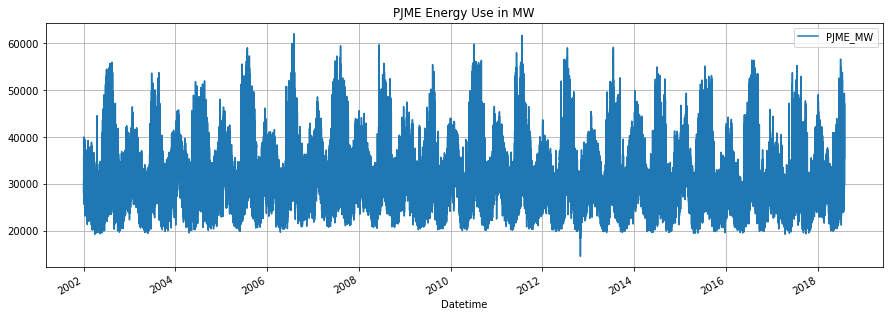

In [23]:
df.plot(style='-',
        figsize=(15, 5),
        #color=color_pal[0],
        title='PJME Energy Use in MW')
plt.grid()
plt.show()

## Train / Test Split

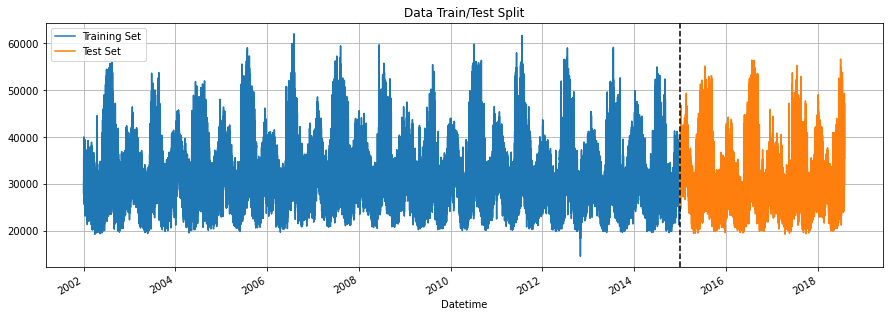

In [24]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.grid()
plt.show()

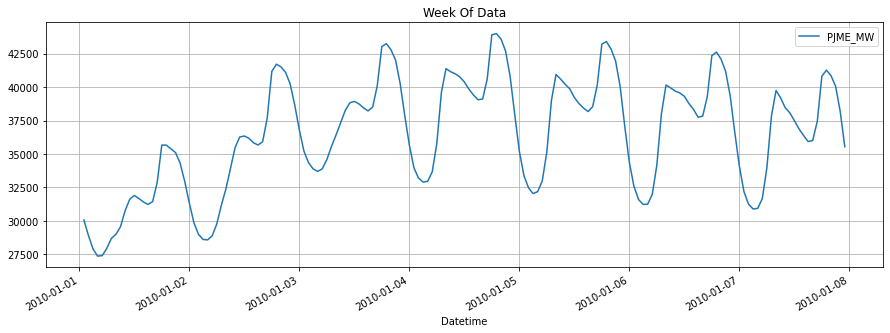

In [25]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')

plt.grid()
plt.show()

## Feature Creation

In [26]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

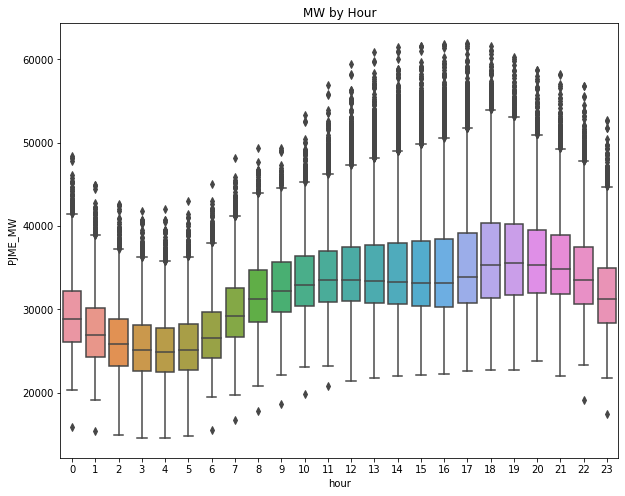

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

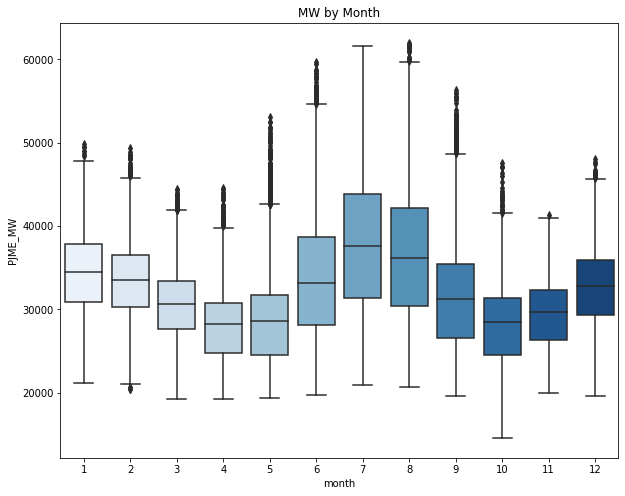

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Modeling XGBooost
XGBoost stands for “Extreme Gradient Boosting”. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable. It implements Machine Learning algorithms under the Gradient Boosting framework. It provides a parallel tree boosting to solve many data science problems in a fast and accurate way.

- Gradient Boosting algorithm also called gradient boosting machine including the learning rate.
- Stochastic Gradient Boosting with sub-sampling at the row, column, and column per split levels.
- Regularized Gradient Boosting with both L1 and L2 regularization.

## System Features
The library provides a system for use in a range of computing environments, not least:

- Parallelization of tree construction using all of your CPU cores during training.
- Distributed Computing for training very large models using a cluster of machines.
- Out-of-Core Computing for very large datasets that don’t fit into memory.
- Cache Optimization of data structures and algorithm to make the best use of hardware.

## Algorithm Features
The implementation of the algorithm was engineered for the efficiency of computing time and memory resources. A design goal was to make the best use of available resources to train the model. Some key algorithm implementation features include:

- Sparse Aware implementation with automatic handling of missing data values.
- Block Structure to support the parallelization of tree construction.
- Continued Training so that you can further boost an already fitted model on new data.

## XGBoost Features
- Regularized Learning: The regularization term helps to smooth the final learned weights to avoid over-fitting. The regularized objective will tend to select a model employing simple and predictive functions.
- Gradient Tree Boosting: The tree ensemble model cannot be optimized using traditional optimization methods in Euclidean space. Instead, the model is trained in an additive manner.
- Shrinkage and Column Subsampling: Besides the regularized objective, two additional techniques are used to further prevent overfitting. The first technique is shrinkage introduced by Friedman. Shrinkage scales newly added weights by a factor η after each step of tree boosting. Similar to a learning rate in stochastic optimization, shrinkage reduces the influence of each tree and leaves space for future trees to improve the model.

In [29]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [30]:
model = xgb.XGBRegressor(base_score=0.5, 
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01
                       )
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Feature Importance

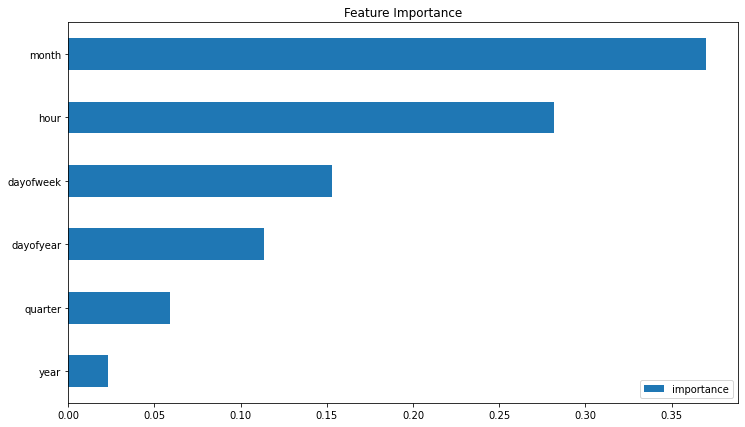

In [31]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(model.feature_importances_)

fi = pd.DataFrame(data=values, index=keys, columns=["importance"])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance',figsize=(12,7));

## Forecast on Test

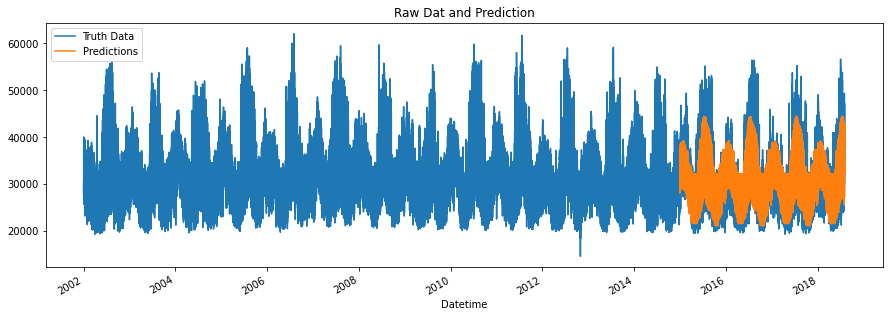

In [32]:
test['prediction'] = model.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

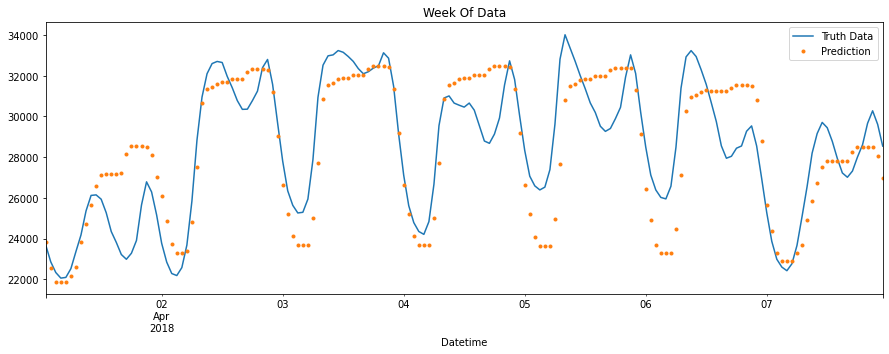

In [14]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')

plt.legend(['Truth Data','Prediction'])
plt.show()

## Score (RMSE+MAPE)

In [18]:
from sklearn.metrics import mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f"RMSE Score on Test set: {rmse:0.2f}")

mape = mean_absolute_percentage_error(test['PJME_MW'], test['prediction'])
print(f"MAPE Score on Test set: {mape:0.2f}")

RMSE Score on Test set: 3721.75
MAPE Score on Test set: 0.09


## Calculate Error
- Look at the worst and best predicted days

In [19]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64